# ⚛️ H₂ VQE — Ansatz Comparison (Noiseless)

This notebook compares **different variational ansätze** for ground-state VQE.
It consists of two *intentionally different* parts:

---
## 🧩 Part A — Educational Toy Ansätze (Manual VQE)

This section:
- defines **simple pedagogical ansätze** entirely inside this notebook  
- uses **tiny circuits** to teach expressivity and circuit structure  
- runs **manual optimisation loops**  

These *toy* circuits are **not meant to match** the production ansätze used by the
VQE package. Their convergence curves will naturally differ.

---
## 🟦 Part B — Production-Level Ansatz Comparison

This section:

```python
from vqe.core import run_vqe_ansatz_comparison
```

and evaluates *real* package-defined ansätze with:
- automatic device construction  
- reproducible parameter initialisation  
- caching  
- full integration with molecule + mapping infrastructure  

The results here represent the **research workflow**, not the simplified examples.

# 🧩 Part A — Educational (Manual) Ansatz Comparison

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

np.random.seed(0)

## Step 1 — Build Hamiltonian

In [ ]:
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])
basis = "STO-3G"

H, num_qubits = qchem.molecular_hamiltonian(symbols, coordinates, basis=basis)
dev = qml.device("default.qubit", wires=num_qubits)

print("Number of qubits:", num_qubits)

Number of qubits: 4


## Step 2 — Define Toy Ansätze  

These are **simple**, **interpretable**, **low-depth** circuits.

To avoid confusion with production ansätze, we use names prefixed with **Toy-**.

In [ ]:
def toy_minimal(params, wires):
    """Toy 2-qubit minimal entangler."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])

def toy_ry_cz(params, wires):
    """Toy RY layer + CZ entangler (full wires)."""
    for i, w in enumerate(wires):
        qml.RY(params[i], wires=w)
    qml.CZ(wires=[wires[0], wires[1]])

def toy_two_qubit_ry_cnot(params, wires):
    """Toy expressive 2-qubit circuit."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(-params[0], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

toy_ansatzes = {
    "Toy-Minimal": toy_minimal,
    "Toy-RY-CZ": toy_ry_cz,
    "Toy-TwoQubit-RY-CNOT": toy_two_qubit_ry_cnot,
}

## Step 3 — Build cost functions

In [ ]:
def make_cost(ansatz_fn, num_params):
    @qml.qnode(dev)
    def cost(params):
        ansatz_fn(params, wires=range(num_qubits))
        return qml.expval(H)
    return cost

## Step 4 — Run manual VQE loops (Adam)

This is purely educational: **no caching**, **no molecule helpers**, **no package code**.

In [ ]:
from vqe.optimizer import get_optimizer

steps = 75
stepsize = 0.2
results_A = {}

for name, fn in toy_ansatzes.items():
    if name == "Toy-RY-CZ":
        num_params = num_qubits
    else:
        num_params = 1

    print(f"\nRunning educational VQE with ansatz = {name}")
    params = 0.05 * np.random.randn(num_params, requires_grad=True)
    opt = get_optimizer("Adam", stepsize)

    cost = make_cost(fn, num_params)
    energies = []

    for _ in range(steps):
        params, prev = opt.step_and_cost(cost, params)
        energies.append(float(prev))

    results_A[name] = {"energies": energies, "params": params}


Running educational VQE with ansatz = Toy-Minimal

Running educational VQE with ansatz = Toy-RY-CZ

Running educational VQE with ansatz = Toy-TwoQubit-RY-CNOT


## Step 5 — Plot toy convergence curves  

⚠️ **Important:** These curves are expected to differ from the Part B results.

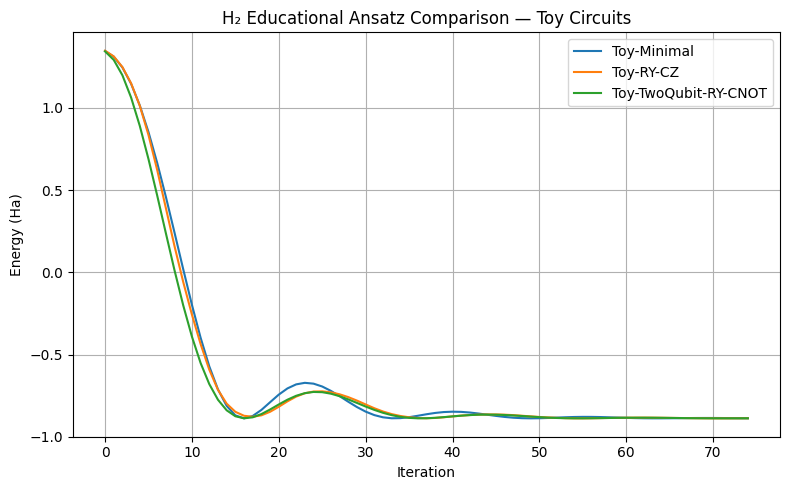

In [ ]:
plt.figure(figsize=(8, 5))
for name, data in results_A.items():
    plt.plot(data["energies"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ Educational Ansatz Comparison — Toy Circuits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 6 — Draw toy circuits


Toy-Minimal circuit:


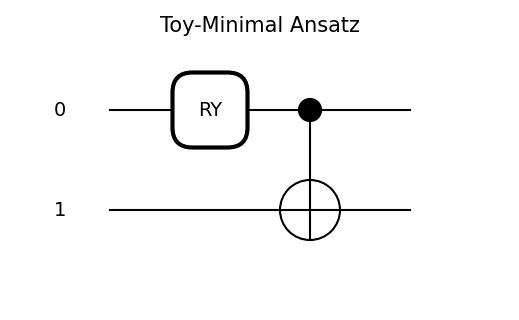


Toy-RY-CZ circuit:


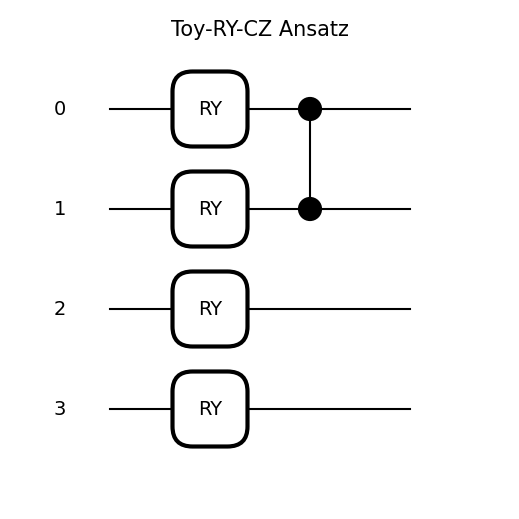


Toy-TwoQubit-RY-CNOT circuit:


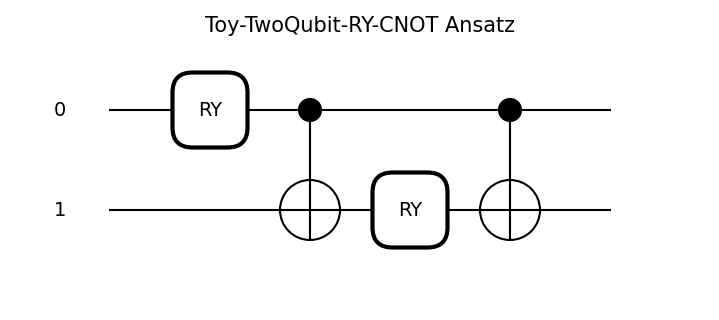

In [ ]:
for name, fn in toy_ansatzes.items():
    params = results_A[name]["params"]

    print(f"\n{name} circuit:")
    fig, ax = qml.draw_mpl(fn)(params, wires=range(num_qubits))
    fig.suptitle(f"{name} Ansatz", fontsize=15)
    plt.show()

# 🟦 Part B — Production-Level Ansatz Comparison

This uses:

```python
run_vqe_ansatz_comparison(...)
```

and evaluates **real package-defined ansätze** with:
- correct wire counts  
- correct parameter initialisation  
- caching  
- device + mapping abstraction  
- full reproducibility  

**These results are not expected to match the toy circuits in Part A.**


🔹 Running ansatz: Minimal
Step 01/75: E = 0.713612 Ha
Step 02/75: E = 0.692164 Ha
Step 03/75: E = 0.649641 Ha
Step 04/75: E = 0.579497 Ha
Step 05/75: E = 0.482266 Ha
Step 06/75: E = 0.359728 Ha
Step 07/75: E = 0.214881 Ha
Step 08/75: E = 0.051977 Ha
Step 09/75: E = -0.123483 Ha
Step 10/75: E = -0.304849 Ha
Step 11/75: E = -0.484535 Ha
Step 12/75: E = -0.654375 Ha
Step 13/75: E = -0.806176 Ha
Step 14/75: E = -0.932467 Ha
Step 15/75: E = -1.027441 Ha
Step 16/75: E = -1.088003 Ha
Step 17/75: E = -1.114649 Ha
Step 18/75: E = -1.111816 Ha
Step 19/75: E = -1.087299 Ha
Step 20/75: E = -1.050700 Ha
Step 21/75: E = -1.011428 Ha
Step 22/75: E = -0.977043 Ha
Step 23/75: E = -0.952462 Ha
Step 24/75: E = -0.939988 Ha
Step 25/75: E = -0.939805 Ha
Step 26/75: E = -0.950573 Ha
Step 27/75: E = -0.969970 Ha
Step 28/75: E = -0.995118 Ha
Step 29/75: E = -1.022935 Ha
Step 30/75: E = -1.050435 Ha
Step 31/75: E = -1.075008 Ha
Step 32/75: E = -1.094660 Ha
Step 33/75: E = -1.108190 Ha
Step 34/75: E = -1.11528

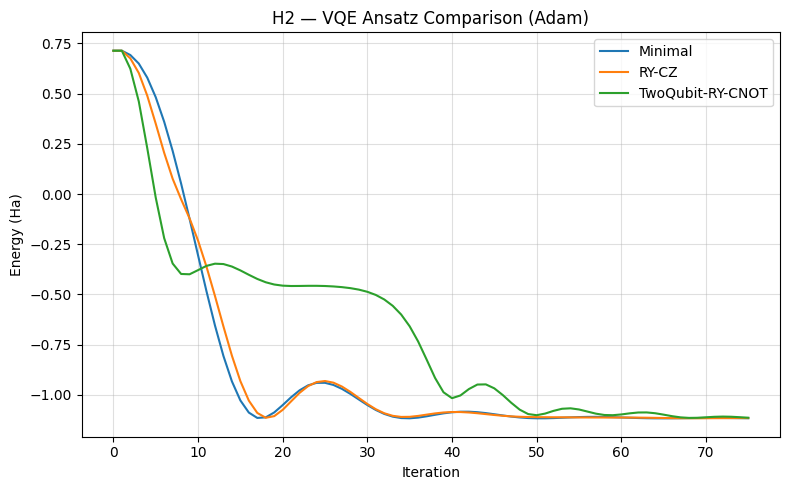


✅ Ansatz comparison complete for H2 (Adam)


In [ ]:
from vqe.core import run_vqe_ansatz_comparison

results_B = run_vqe_ansatz_comparison(
    molecule="H2",
    optimizer_name="Adam",
    ansatzes=["Minimal", "RY-CZ", "TwoQubit-RY-CNOT"],  # production ansätze
    steps=75,
    stepsize=0.2,
    noisy=False,
)